In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score

In [2]:
def compute_graph_covariance(df: pd.DataFrame, time_col: str = 't') -> dict:
    """
    Computes a 'graph covariance'-like matrix for each unique time step in `df`,
    returning each matrix as a DataFrame (so .loc indexing is supported).
    
    Steps:
      1. Split the data by unique time values,
      2. For each time step, convert the sub-DataFrame (minus the time column)
         to a NumPy array,
      3. Subtract the mean from each column (center the data),
      4. Normalize each column by its standard deviation,
      5. Compute the covariance-like matrix for that time step,
      6. Return a dictionary keyed by time with the resulting DataFrame.

    Returns
    -------
    dict
        Dictionary where each key is a unique time value and the value is a
        DataFrame containing the covariance-like matrix.
    """
    # Identify all columns other than time_col
    other_cols = [col for col in df.columns if col != time_col]
    
    # Split data into time steps
    unique_times = df[time_col].unique()
    gc_dict = {}

    for t_value in unique_times:
        # Subset the DataFrame to the current time step
        subset_df = df[df[time_col] == t_value].drop(columns=[time_col])
        data_t = subset_df.values.astype(float)

        if data_t.shape[0] < 2:
            continue

        # Mean-center the data
        n = data_t.shape[0]
        mean = data_t.mean(axis=0, keepdims=True)
        data_centered = data_t - mean

        # Normalize each column
        stds = data_centered.std(axis=0, ddof=1, keepdims=True)
        
        # Avoid division by zero
        stds[stds == 0] = 1.0
        data_centered /= stds

        # Compute the covariance-like matrix
        graph_covariance = (data_centered.T @ data_centered) / (n - 1)

        # Convert to DataFrame
        cov_df = pd.DataFrame(graph_covariance, 
                              index=subset_df.columns, 
                              columns=subset_df.columns)
        
        # Store the DataFrame
        gc_dict[t_value] = cov_df

    return gc_dict

# Graphing one csv

In [14]:
df = pd.read_csv("Simulated Data/simple_gen_data_new.csv")
gc_matrices = compute_graph_covariance(df, time_col="t")

print("Graph covariance matrices by time:")
for t, mat in gc_matrices.items():
    print(f"\nTime {t}:")
    print(mat.round(3))

Graph covariance matrices by time:

Time 1:
       X1     X2     X3     X4     X5     X6     X7
X1  1.000 -0.009  0.946  0.389  0.883  0.792  0.010
X2 -0.009  1.000 -0.007 -0.005 -0.015 -0.005 -0.000
X3  0.946 -0.007  1.000  0.367  0.825  0.760  0.012
X4  0.389 -0.005  0.367  1.000  0.348  0.287  0.007
X5  0.883 -0.015  0.825  0.348  1.000  0.708  0.017
X6  0.792 -0.005  0.760  0.287  0.708  1.000  0.022
X7  0.010 -0.000  0.012  0.007  0.017  0.022  1.000

Time 2:
       X1     X2     X3     X4     X5     X6     X7
X1  1.000 -0.001  0.932  0.451  0.848  0.762 -0.016
X2 -0.001  1.000 -0.001 -0.025  0.002 -0.001 -0.000
X3  0.932 -0.001  1.000  0.423  0.791  0.715 -0.017
X4  0.451 -0.025  0.423  1.000  0.364  0.332 -0.012
X5  0.848  0.002  0.791  0.364  1.000  0.652 -0.012
X6  0.762 -0.001  0.715  0.332  0.652  1.000 -0.017
X7 -0.016 -0.000 -0.017 -0.012 -0.012 -0.017  1.000

Time 3:
       X1     X2     X3     X4     X5     X6     X7
X1  1.000 -0.012  0.944  0.472  0.818  0.714 -0.007
X2

In [15]:
times = sorted(gc_matrices.keys())

gc_12 = [gc_matrices[t].loc["X1","X2"] for t in times]  # (X1, X2)
gc_13 = [gc_matrices[t].loc["X1","X3"] for t in times]  # (X1, X3)
gc_14 = [gc_matrices[t].loc["X1","X4"] for t in times]  # (X1, X4)
gc_15 = [gc_matrices[t].loc["X1","X5"] for t in times]  # (X1, X5)
gc_16 = [gc_matrices[t].loc["X1","X6"] for t in times]  # (X1, X6)
gc_17 = [gc_matrices[t].loc["X1","X7"] for t in times]  # (X1, X7)

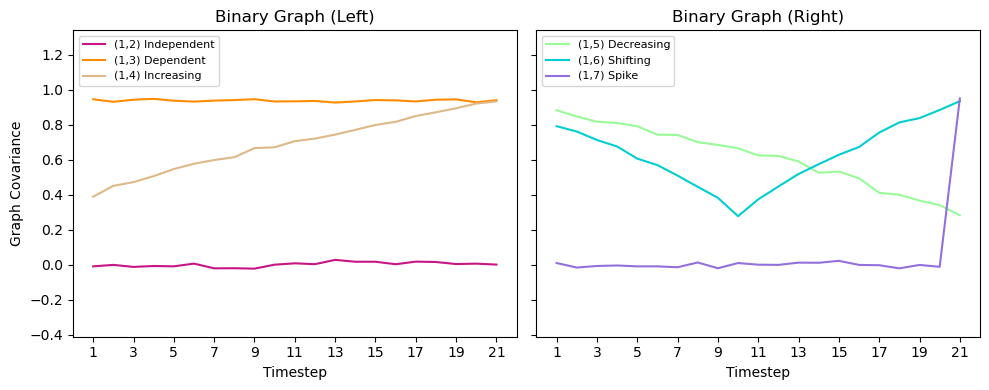

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Left: (X1,X2), (X1,X3), (X1,X4)
ax1.plot(times, gc_12, color='mediumvioletred', label='(1,2) Independent')
ax1.plot(times, gc_13, color='darkorange', label='(1,3) Dependent')
ax1.plot(times, gc_14, color='burlywood', label='(1,4) Increasing')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Graph Covariance')
ax1.set_title('Binary Graph (Left)')
ax1.legend(loc='upper left', fontsize='8')

# Right: (X1,X5), (X1,X6), (X1,X7)
ax2.plot(times, gc_15, color='palegreen', label='(1,5) Decreasing')
ax2.plot(times, gc_16, color='darkturquoise', label='(1,6) Shifting')
ax2.plot(times, gc_17, color='mediumpurple', label='(1,7) Spike')
ax2.set_xlabel('Timestep')
ax2.set_title('Binary Graph (Right)')
ax2.legend(loc='upper left', fontsize='8')

# Combine all data to determine the overall min and max
all_data = np.concatenate([gc_12, gc_13, gc_14, gc_15, gc_16, gc_17])
global_min = np.min(all_data)
global_max = np.max(all_data)

# Calculate a 20% margin on the range
data_range = global_max - global_min
margin = 0.4 * data_range

# Set the y-axis limits with an extra 20% margin
y_lower = global_min - margin
y_upper = global_max + margin
ax1.set_ylim(y_lower, y_upper)
ax2.set_ylim(y_lower, y_upper)

# Set x-axis limits from 0 to 22 and ticks at 1, 4, 7, ... up to 21
xticks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
ax1.set_xlim(0, 22)
ax2.set_xlim(0, 22)
ax1.set_xticks(xticks)
ax2.set_xticks(xticks)

plt.tight_layout()
plt.show()

# Graphing two csvs

In [251]:
# Load two CSV files
df1 = pd.read_csv("Data/Simulated Data/New Simulated Data t=21/simple_gen_data_new.csv") # Original "ground truth"
df2 = pd.read_csv("Data/Simulated Data/New Simulated Data t=21/kNN/10k26 Average/simple_gen_kNNavg7k26_impute_binary.csv") # Imputed dataset

In [252]:
# Compute graph covariance for both datasets
gc_matrices1 = compute_graph_covariance(df1, time_col="t")
gc_matrices2 = compute_graph_covariance(df2, time_col="t")

# Ensure times are aligned (using intersection of time points)
times1 = sorted(gc_matrices1.keys())
times2 = sorted(gc_matrices2.keys())
common_times = sorted(set(times1) & set(times2))

In [253]:
# Extract covariance values for both datasets
gc1_12 = [gc_matrices1[t].loc["X1","X2"] for t in common_times]
gc1_13 = [gc_matrices1[t].loc["X1","X3"] for t in common_times]
gc1_14 = [gc_matrices1[t].loc["X1","X4"] for t in common_times]
gc1_15 = [gc_matrices1[t].loc["X1","X5"] for t in common_times]
gc1_16 = [gc_matrices1[t].loc["X1","X6"] for t in common_times]
gc1_17 = [gc_matrices1[t].loc["X1","X7"] for t in common_times]

gc2_12 = [gc_matrices2[t].loc["X1","X2"] for t in common_times]
gc2_13 = [gc_matrices2[t].loc["X1","X3"] for t in common_times]
gc2_14 = [gc_matrices2[t].loc["X1","X4"] for t in common_times]
gc2_15 = [gc_matrices2[t].loc["X1","X5"] for t in common_times]
gc2_16 = [gc_matrices2[t].loc["X1","X6"] for t in common_times]
gc2_17 = [gc_matrices2[t].loc["X1","X7"] for t in common_times]

In [254]:
# Shift second line to match first
def shift_series(base_series, imputed_series):
    """Shift imputed_series so that its first value matches the first value of base_series."""
    offset = base_series[0] - imputed_series[0]
    return [val + offset for val in imputed_series]

gc2_12_shifted = shift_series(gc1_12, gc2_12)
gc2_13_shifted = shift_series(gc1_13, gc2_13)
gc2_14_shifted = shift_series(gc1_14, gc2_14)
gc2_15_shifted = shift_series(gc1_15, gc2_15)
gc2_16_shifted = shift_series(gc1_16, gc2_16)
gc2_17_shifted = shift_series(gc1_17, gc2_17)

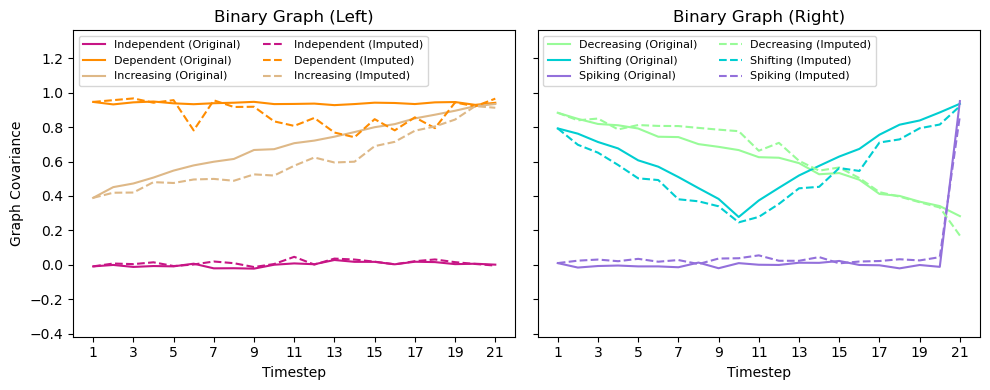

In [255]:
# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# LEFT PLOT: (X1,X2), (X1,X3), (X1,X4)
ax1.plot(common_times, gc1_12, color='mediumvioletred',   linestyle='-',  label='Independent (Original)')
ax1.plot(common_times, gc1_13, color='darkorange',        linestyle='-',  label='Dependent (Original)')
ax1.plot(common_times, gc1_14, color='burlywood',         linestyle='-',  label='Increasing (Original)')
ax1.plot(common_times, gc2_12_shifted, color='mediumvioletred', linestyle='--', label='Independent (Imputed)')
ax1.plot(common_times, gc2_13_shifted, color='darkorange',      linestyle='--', label='Dependent (Imputed)')
ax1.plot(common_times, gc2_14_shifted, color='burlywood',       linestyle='--', label='Increasing (Imputed)')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Graph Covariance')
ax1.set_title('Binary Graph (Left)')
ax1.legend(loc='upper left', fontsize='8', ncol=2)

# RIGHT PLOT: (X1,X5), (X1,X6), (X1,X7)
ax2.plot(common_times, gc1_15, color='palegreen',   linestyle='-', label='Decreasing (Original)')
ax2.plot(common_times, gc1_16, color='darkturquoise', linestyle='-', label='Shifting (Original)')
ax2.plot(common_times, gc1_17, color='mediumpurple', linestyle='-', label='Spiking (Original)')
ax2.plot(common_times, gc2_15_shifted, color='palegreen',   linestyle='--', label='Decreasing (Imputed)')
ax2.plot(common_times, gc2_16_shifted, color='darkturquoise', linestyle='--', label='Shifting (Imputed)')
ax2.plot(common_times, gc2_17_shifted, color='mediumpurple', linestyle='--', label='Spiking (Imputed)')
ax2.set_xlabel('Timestep')
ax2.set_title('Binary Graph (Right)')
ax2.legend(loc='upper left', fontsize='8', ncol=2)

# --- GLOBAL Y-LIMITS ---
all_data_original = np.concatenate([
    gc1_12, gc1_13, gc1_14,
    gc1_15, gc1_16, gc1_17
])
all_data_imputed = np.concatenate([
    gc2_12_shifted, gc2_13_shifted, gc2_14_shifted,
    gc2_15_shifted, gc2_16_shifted, gc2_17_shifted
])
all_data = np.concatenate([all_data_original, all_data_imputed])

global_min = np.min(all_data)
global_max = np.max(all_data)
data_range = global_max - global_min
margin = 0.4 * data_range
y_lower = global_min - margin
y_upper = global_max + margin

ax1.set_ylim(y_lower, y_upper)
ax2.set_ylim(y_lower, y_upper)

# Set x-axis limits from 0 to 22 and ticks at 1, 4, 7, ... up to 21
xticks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
ax1.set_xlim(0, 22)
ax2.set_xlim(0, 22)
ax1.set_xticks(xticks)
ax2.set_xticks(xticks)

plt.tight_layout()
plt.show()

# Calculating Imputation Accuracy

In [ ]:
df_true  = pd.read_csv("Data/Simulated Data/New Simulated Data t=21/simple_gen_data_new.csv") # Original "ground truth"
df_imputed = pd.read_csv("Data/Simulated Data/New Simulated Data t=21/kNN/10k26 Majority/simple_gen_kNNavg2k26_impute_binary.csv") # Imputed dataset

In [199]:
cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

assert df_true.shape[0] == df_imputed.shape[0], "Dataframes do not have the same number of rows"
assert all(df_true['t'] == df_imputed['t']), "The time columns do not match row by row"

In [200]:
print("Percentage of 0s and 1s in original dataset (per variable):")
for col in cols:
    pct_0 = (df_true[col] == 0).mean() * 100
    pct_1 = (df_true[col] == 1).mean() * 100
    print(f"{col}: 0 -> {pct_0:.2f}%, 1 -> {pct_1:.2f}%")

Percentage of 0s and 1s in original dataset (per variable):
X1: 0 -> 80.17%, 1 -> 19.83%
X2: 0 -> 89.93%, 1 -> 10.07%
X3: 0 -> 82.11%, 1 -> 17.89%
X4: 0 -> 89.09%, 1 -> 10.91%
X5: 0 -> 91.07%, 1 -> 8.93%
X6: 0 -> 90.68%, 1 -> 9.32%
X7: 0 -> 89.86%, 1 -> 10.14%


## For binary values

In [201]:
y_true = df_true[cols].values.flatten()      # Flatten 2D array into 1D
y_imputed = df_imputed[cols].values.flatten()

In [202]:
def shift_series(base_series, imputed_series):
    """
    Shift imputed_series so that its first value matches 
    the first value of base_series.
    """
    if not base_series:  # if empty
        return imputed_series
    offset = base_series[0] - imputed_series[0]
    return [val + offset for val in imputed_series]

def mean_squared_error(series1, series2):
    diff = np.array(series1) - np.array(series2)
    return np.mean(diff ** 2)

def mean_absolute_error(series1, series2):
    diff = np.array(series1) - np.array(series2)
    return np.mean(np.abs(diff))

def pearson_correlation(series1, series2):
    return np.corrcoef(series1, series2)[0, 1]

In [203]:
# Compute graph covariance matrices (assuming compute_graph_covariance is defined)
gc_matrices1 = compute_graph_covariance(df_true, time_col="t")
gc_matrices2 = compute_graph_covariance(df_imputed, time_col="t")

times1 = sorted(gc_matrices1.keys())
times2 = sorted(gc_matrices2.keys())
common_times = sorted(set(times1) & set(times2))

# Extract covariance values for pairs: (X1,X2), (X1,X3), ..., (X1,X7)
gc1_12 = [gc_matrices1[t].loc["X1", "X2"] for t in common_times] if common_times else []
gc1_13 = [gc_matrices1[t].loc["X1", "X3"] for t in common_times] if common_times else []
gc1_14 = [gc_matrices1[t].loc["X1", "X4"] for t in common_times] if common_times else []
gc1_15 = [gc_matrices1[t].loc["X1", "X5"] for t in common_times] if common_times else []
gc1_16 = [gc_matrices1[t].loc["X1", "X6"] for t in common_times] if common_times else []
gc1_17 = [gc_matrices1[t].loc["X1", "X7"] for t in common_times] if common_times else []

gc2_12 = [gc_matrices2[t].loc["X1", "X2"] for t in common_times] if common_times else []
gc2_13 = [gc_matrices2[t].loc["X1", "X3"] for t in common_times] if common_times else []
gc2_14 = [gc_matrices2[t].loc["X1", "X4"] for t in common_times] if common_times else []
gc2_15 = [gc_matrices2[t].loc["X1", "X5"] for t in common_times] if common_times else []
gc2_16 = [gc_matrices2[t].loc["X1", "X6"] for t in common_times] if common_times else []
gc2_17 = [gc_matrices2[t].loc["X1", "X7"] for t in common_times] if common_times else []

# Shift the imputed series so that the starting values match the original ones
gc2_12_shifted = shift_series(gc1_12, gc2_12)
gc2_13_shifted = shift_series(gc1_13, gc2_13)
gc2_14_shifted = shift_series(gc1_14, gc2_14)
gc2_15_shifted = shift_series(gc1_15, gc2_15)
gc2_16_shifted = shift_series(gc1_16, gc2_16)
gc2_17_shifted = shift_series(gc1_17, gc2_17)

pairs_original = [gc1_12, gc1_13, gc1_14, gc1_15, gc1_16, gc1_17]
pairs_imputed  = [gc2_12_shifted, gc2_13_shifted, gc2_14_shifted,
                  gc2_15_shifted, gc2_16_shifted, gc2_17_shifted]
pair_names = ["(X1,X2)", "(X1,X3)", "(X1,X4)", "(X1,X5)", "(X1,X6)", "(X1,X7)"]

In [204]:
pearson_values = []
nmse_values = []
nmae_values = []

print("\nSimilarity Metrics (using df_true as reference for normalization):")
for orig_series, imp_series, name in zip(pairs_original, pairs_imputed, pair_names):
    if len(orig_series) == 0 or len(imp_series) == 0:
        print(f"\nNo data for pair {name}; cannot compute metrics.")
        pearson_values.append(np.nan)
        nmse_values.append(np.nan)
        nmae_values.append(np.nan)
        continue

    # Compute Pearson correlation
    pearson_val = pearson_correlation(orig_series, imp_series)
    
    # Compute errors
    mse_val = mean_squared_error(orig_series, imp_series)
    mae_val = mean_absolute_error(orig_series, imp_series)
    
    # Compute range R from the ground truth (df_true) for this pair
    R = np.max(orig_series) - np.min(orig_series)
    if R == 0:
        nmse_val = np.nan
        nmae_val = np.nan
    else:
        nmse_val = mse_val / (R ** 2)
        nmae_val = mae_val / R

    pearson_values.append(pearson_val)
    nmse_values.append(nmse_val)
    nmae_values.append(nmae_val)
    
    print(f"\nMetrics for {name}:")
    print(f"    Pearson Correlation: {pearson_val:.4f}")
    print(f"    NMSE: {nmse_val:.4f}")
    print(f"    NMAE: {nmae_val:.4f}")

# Compute overall averages (ignoring NaNs)
if any(~np.isnan(pearson_values)):
    avg_pearson = np.nanmean(pearson_values)
    avg_nmse = np.nanmean(nmse_values)
    avg_nmae = np.nanmean(nmae_values)
    print(f"\nOverall Averages across all pairs:")
    print(f"    Average Pearson Correlation: {avg_pearson:.4f}")
    print(f"    Average NMSE: {avg_nmse:.4f}")
    print(f"    Average NMAE: {avg_nmae:.4f}")
else:
    print("\nNo valid metric values to compute overall averages.")


Similarity Metrics (using df_true as reference for normalization):

Metrics for (X1,X2):
    Pearson Correlation: 0.5085
    NMSE: 0.1070
    NMAE: 0.2238

Metrics for (X1,X3):
    Pearson Correlation: 0.5150
    NMSE: 50.2736
    NMAE: 5.9134

Metrics for (X1,X4):
    Pearson Correlation: 0.9244
    NMSE: 0.0522
    NMAE: 0.1997

Metrics for (X1,X5):
    Pearson Correlation: 0.9626
    NMSE: 0.0092
    NMAE: 0.0705

Metrics for (X1,X6):
    Pearson Correlation: 0.9781
    NMSE: 0.0044
    NMAE: 0.0479

Metrics for (X1,X7):
    Pearson Correlation: 0.9942
    NMSE: 0.0015
    NMAE: 0.0332

Overall Averages across all pairs:
    Average Pearson Correlation: 0.8138
    Average NMSE: 8.4080
    Average NMAE: 1.0814


## For noncategorical values

In [205]:
y_true = df_true[cols].values.flatten()
y_imputed = df_imputed[cols].values.flatten()

mse_val = mean_squared_error(y_true, y_imputed)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_true, y_imputed)
r2_val = r2_score(y_true, y_imputed)

print("Regression Metrics (all continuous columns combined):")
print(f"MSE:   {mse_val:.3f}")
print(f"RMSE:  {rmse_val:.3f}")
print(f"MAE:   {mae_val:.3f}")
print(f"R^2:   {r2_val:.3f}")

Regression Metrics (all continuous columns combined):
MSE:   0.050
RMSE:  0.223
MAE:   0.050
R^2:   0.545


# Plotting metric results (of multi-kNN)

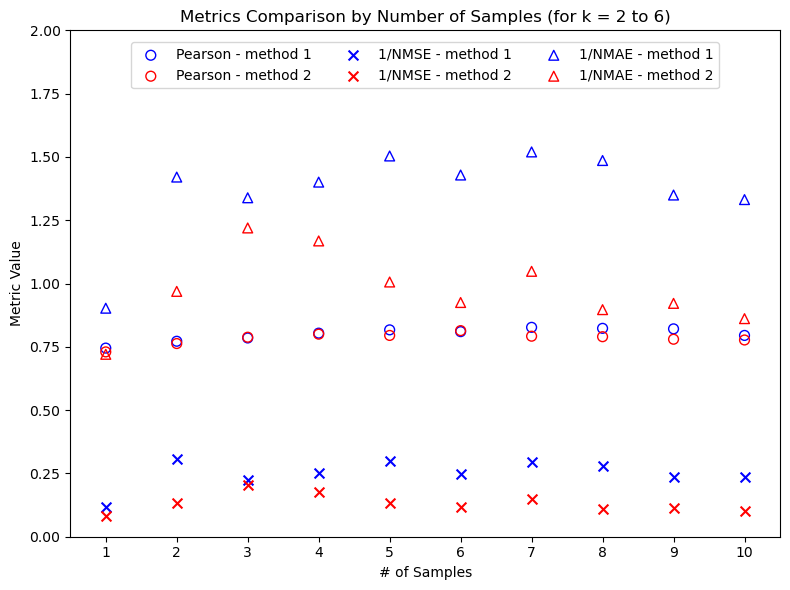

In [244]:
# Read the Excel file (update the filename if necessary)
df = pd.read_excel('Data/Simulated Data/New Simulated Data t=21/kNN/10k26 metric results.xlsx')

# Define marker types and colors
color_method1  = 'blue'
color_method2  = 'red'
marker_pearson = 'o'   # circle
marker_nmse    = 'x'   # cross
marker_nmae    = '^'   # triangle

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot Method 1 metrics
# Pearson (hollow)
p_m1 = ax.scatter(
    df['num_samples'],
    df['pearson_method1'],
    facecolors='none', edgecolors=color_method1, marker=marker_pearson, s=50,
    label='Pearson M1'
)

# 1/NMSE (solid)
n_m1 = ax.scatter(
    df['num_samples'],
    1 / df['nmse_method1'],  # invert NMSE
    color=color_method1, marker=marker_nmse, s=50,
    label='1/NMSE M1'
)

# 1/NMAE (hollow triangle)
a_m1 = ax.scatter(
    df['num_samples'],
    1 / df['nmae_method1'],  # invert NMAE
    facecolors='none', edgecolors=color_method1, marker=marker_nmae, s=50,
    label='1/NMAE M1'
)

# Plot Method 2 metrics
# Pearson (hollow)
p_m2 = ax.scatter(
    df['num_samples'],
    df['pearson_method2'],
    facecolors='none', edgecolors=color_method2, marker=marker_pearson, s=50,
    label='Pearson M2'
)

# 1/NMSE (solid)
n_m2 = ax.scatter(
    df['num_samples'],
    1 / df['nmse_method2'],  # invert NMSE
    color=color_method2, marker=marker_nmse, s=50,
    label='1/NMSE M2'
)

# 1/NMAE (hollow triangle)
a_m2 = ax.scatter(
    df['num_samples'],
    1 / df['nmae_method2'],  # invert NMAE
    facecolors='none', edgecolors=color_method2, marker=marker_nmae, s=50,
    label='1/NMAE M2'
)

# Axis settings
ax.set_xlabel('# of Samples')
ax.set_ylabel('Metric Value')
ax.set_title('Metrics Comparison by Number of Samples (for k = 2 to 6)')
ax.set_xlim(0.5, 10.5)
ax.set_ylim(0, 2)
ax.grid(True)

# Set x-axis ticks at every integer from 1 to 10
ax.set_xticks(range(1, 11))
ax.grid(False)

# Combine legend handles
lns = [p_m1, p_m2, n_m1, n_m2, a_m1, a_m2]
labs = ['Pearson - method 1', 'Pearson - method 2', '1/NMSE - method 1', '1/NMSE - method 2', '1/NMAE - method 1', '1/NMAE - method 2']

# Legend in 3 columns
ax.legend(
    lns,
    labs,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.99),
    ncol=3
)

plt.tight_layout()
plt.show()